# Kaggle Competition Notebook

- Author: Hasnain Yaqoob
- LinkedIn: https://www.linkedin.com/in/hasnain-yaqoob/
- GitHub: https://github.com/hasnainyaqoob


# Survival Rate Prediction on Titanic Dataset using Machine Learning Models 

In [217]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import OneHotEncoder , LabelEncoder , StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error, r2_score, mean_squared_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [218]:
# load the data
df_train = pd.read_csv('/content/train.csv')
df_test = pd.read_csv('/content/test.csv')
submission = pd.read_csv('/content/gender_submission.csv')

In [219]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [220]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [221]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


# Let's explore the data

In [222]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [223]:
((df_train.isnull().sum() / df_train.shape[0]) * 100).sort_values(ascending=False)

,0
Cabin,77.104377
Age,19.865320
Embarked,0.224467
PassengerId,0.000000
Name,0.000000
Pclass,0.000000
Survived,0.000000
Sex,0.000000
Parch,0.000000
SibSp,0.000000


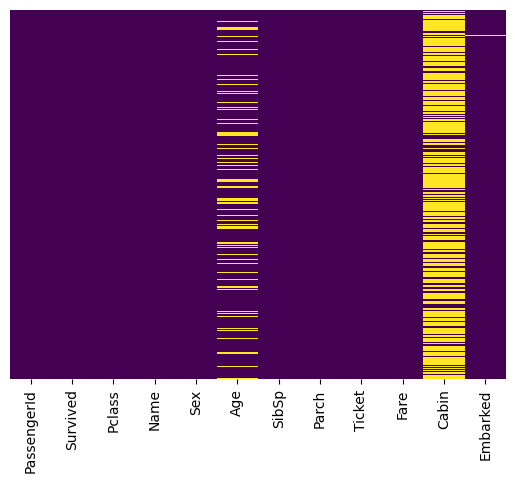

In [224]:
# lets see how many missing values we have in the data by creating a plot

sns.heatmap(df_train.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.show()

------------
# Dealing with missing values

In [225]:
df = df_train
# let's split the  columns with missing values into list
df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False)
missing_data_cols = df.isnull().sum()[df.isnull().sum() > 0].index.tolist()
print(missing_data_cols)
# let's split the columns with missing values into categorical and numeric columns
categorical_cols = [col for col in df.columns if df_train[col].dtypes == 'O']
bool_cols = []
numeric_cols = [col for col in df.columns if df_train[col].dtypes == 'float64']

['Age', 'Cabin', 'Embarked']


In [226]:
# define the function to impute the missing values in thal column

def impute_categorical_missing_data(passed_col):

    df_null = df[df[passed_col].isnull()]
    df_not_null = df[df[passed_col].notnull()]

    X = df_not_null.drop(passed_col, axis=1)
    y = df_not_null[passed_col]

    other_missing_cols = [col for col in missing_data_cols if col != passed_col]

    label_encoder = LabelEncoder()

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    if passed_col in bool_cols:
        y = label_encoder.fit_transform(y)

    iterative_imputer = IterativeImputer(estimator=RandomForestRegressor(random_state=42), add_indicator=True)

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_classifier = RandomForestClassifier()

    rf_classifier.fit(X_train, y_train)

    y_pred = rf_classifier.predict(X_test)

    acc_score = accuracy_score(y_test, y_pred)

    print("The feature '"+ passed_col+ "' has been imputed with", round((acc_score * 100), 2), "accuracy\n")

    X = df_null.drop(passed_col, axis=1)

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass

    if len(df_null) > 0:
        df_null[passed_col] = rf_classifier.predict(X)
        if passed_col in bool_cols:
            df_null[passed_col] = df_null[passed_col].map({0: False, 1: True})
        else:
            pass
    else:
        pass

    df_combined = pd.concat([df_not_null, df_null])

    return df_combined[passed_col]

def impute_continuous_missing_data(passed_col):

    df_null = df[df[passed_col].isnull()]
    df_not_null = df[df[passed_col].notnull()]

    X = df_not_null.drop(passed_col, axis=1)
    y = df_not_null[passed_col]

    other_missing_cols = [col for col in missing_data_cols if col != passed_col]

    label_encoder = LabelEncoder()

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    iterative_imputer = IterativeImputer(estimator=RandomForestRegressor(random_state=42), add_indicator=True)

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_regressor = RandomForestRegressor()

    rf_regressor.fit(X_train, y_train)

    y_pred = rf_regressor.predict(X_test)

    print("MAE =", mean_absolute_error(y_test, y_pred), "\n")
    # print("RMSE =", mean_squared_error(y_test, y_pred, squared=False), "\n")
    print("R2 =", r2_score(y_test, y_pred), "\n")

    X = df_null.drop(passed_col, axis=1)

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass

    if len(df_null) > 0:
        df_null[passed_col] = rf_regressor.predict(X)
    else:
        pass

    df_combined = pd.concat([df_not_null, df_null])

    return df_combined[passed_col]

In [227]:
# impute missing values using our functions
for col in missing_data_cols:
    print("Missing Values", col, ":", str(round((df[col].isnull().sum() / len(df)) * 100, 2))+"%")
    if col in categorical_cols:
        df[col] = impute_categorical_missing_data(col)
    elif col in numeric_cols:
        df[col] = impute_continuous_missing_data(col)
        pass
    else:
        pass

Missing Values Age : 19.87%
MAE = 9.328265034965034 

R2 = 0.2587405086559429 

Missing Values Cabin : 77.1%
The feature 'Cabin' has been imputed with 26.83 accuracy

Missing Values Embarked : 0.22%
The feature 'Embarked' has been imputed with 89.33 accuracy



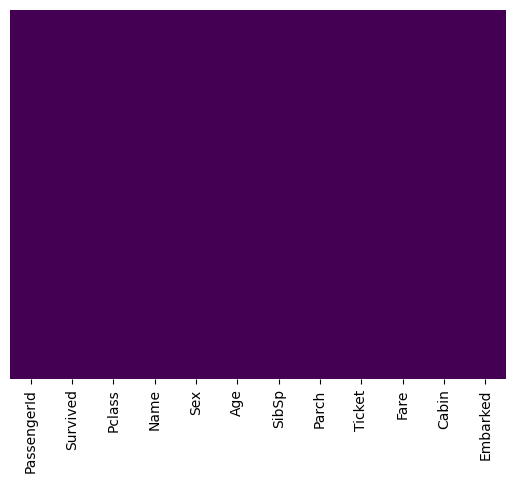

In [228]:
# plot missing values

sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.show()


In [229]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,G6,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,G6,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,E10,S


In [230]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.50,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.00,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.00,3.0000
Age,891.0,29.742115,13.541539,0.42,22.0000,29.0000,36.34,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.00,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.00,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.00,512.3292


# Feature

In [231]:
# lets impute faregroup null values with itrative imputer
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        891 non-null    object 
 11  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [232]:
# lets encode the categorical columns
le_list = {}

for col in df.columns:
    if df[col].dtype == 'object' or df[col].dtype == 'category':
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        le_list[col] = le

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,108,1,22.0,1,0,523,7.2500,145,2
1,2,1,1,190,0,38.0,1,0,596,71.2833,81,0
2,3,1,3,353,0,26.0,0,0,669,7.9250,145,2
3,4,1,1,272,0,35.0,1,0,49,53.1000,55,2
4,5,0,3,15,1,35.0,0,0,472,8.0500,115,2


In [233]:
# # lets normalize the numeric columns
scaler = StandardScaler()

for col in numeric_cols:
    df[col] = scaler.fit_transform(df[col].values.reshape(-1, 1))

In [234]:
# Split the data into X and y
X = df.drop('Survived', axis=1)
y = df['Survived']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Building

In [253]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=6),
    'Random Forest': RandomForestClassifier(n_estimators=100,  random_state = 24),
    'Gradient Boosting': GradientBoostingClassifier(random_state=46),
    'SVM': SVC(random_state=24),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=19),
    'CatBoost': CatBoostClassifier(verbose=0,  random_state = 34)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    results[name] = acc

    # Sort and show top models
top_models = sorted(results.items(), key=lambda x: x[1], reverse=True)
for model, score in top_models[:]:
    print(f"{model}: {score:.4f}")

Gradient Boosting: 0.8436
CatBoost: 0.8436
XGBoost: 0.8268
Random Forest: 0.8212
Logistic Regression: 0.7989
SVM: 0.5866


In [251]:
# Range of random states to try
random_states = list(range(0, 51,1))  # 0, 5, 10, ..., 50

# Dictionary to store best result per model
best_results = {}

# Run loop
for name, model in models.items():
    print(f"\nEvaluating: {name}")
    best_score = 0
    best_rs = None

    for rs in random_states:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rs)

        try:
            model.fit(X_train, y_train)
            preds = model.predict(X_test)
            acc = accuracy_score(y_test, preds)

            if acc > best_score:
                best_score = acc
                best_rs = rs
        except Exception as e:
            print(f"Error in {name} at random_state {rs}: {e}")
            continue

    best_results[name] = {
        'Best Accuracy': best_score,
        'Best Random State': best_rs
    }

# Show sorted top models
print("\nTop Models (Accuracy and Best Random State):")
sorted_results = sorted(best_results.items(), key=lambda x: x[1]['Best Accuracy'], reverse=True)

for name, res in sorted_results:
    print(f"{name}: Accuracy = {res['Best Accuracy']:.4f}, Random State = {res['Best Random State']}")



Evaluating: Logistic Regression

Evaluating: Random Forest

Evaluating: Gradient Boosting

Evaluating: SVM

Evaluating: XGBoost

Evaluating: CatBoost

Top Models (Accuracy and Best Random State):
CatBoost: Accuracy = 0.8994, Random State = 34
Random Forest: Accuracy = 0.8939, Random State = 11
Gradient Boosting: Accuracy = 0.8939, Random State = 18
Logistic Regression: Accuracy = 0.8827, Random State = 6
XGBoost: Accuracy = 0.8771, Random State = 19
SVM: Accuracy = 0.7151, Random State = 24


In [ ]:
# Pick the best performing model from sorted results
best_model = sorted_results[0] 

import joblib
# Get the actual model object with the best random_state
final_model_class = models[best_model[0]]
best_random_state = best_model[1]['Best Random State']

# Re-train it on that best random_state
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=best_random_state)
final_model_class.fit(X_train, y_train)

# Save it to file
joblib.dump(final_model_class, f"{best_model[0].replace(' ', '_')}_best_model.pkl")

print(f"\nSaved {best_model[0]} model to file: {best_model[0].replace(' ', '_')}_best_model.pkl")



💾 Saved CatBoost model to file: CatBoost_best_model.pkl


In [256]:
loaded_model = joblib.load("/content/CatBoost_best_model.pkl")
predictions = loaded_model.predict(X_test)

pred_acc = accuracy_score(y_test, predictions)
print("Accuracy:", pred_acc)


Accuracy: 0.8994413407821229


# Exploring the test data

In [258]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [261]:
df_test.isna().sum()

,0
PassengerId,0
Pclass,0
Name,0
Sex,0
Age,86
SibSp,0
Parch,0
Ticket,0
Fare,1
Cabin,327


# Imputing the missing values in the test data


In [263]:
df = df_test
# let's split the  columns with missing values into list
df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False)
missing_data_cols = df.isnull().sum()[df.isnull().sum() > 0].index.tolist()
print(missing_data_cols)
# let's split the columns with missing values into categorical and numeric columns
categorical_cols = [col for col in df.columns if df_train[col].dtypes == 'O']
bool_cols = []
numeric_cols = [col for col in df.columns if df_train[col].dtypes == 'float64']


['Age', 'Fare', 'Cabin']


In [262]:
# define the function to impute the missing values in thal column

def impute_categorical_missing_data(passed_col):

    df_null = df[df[passed_col].isnull()]
    df_not_null = df[df[passed_col].notnull()]

    X = df_not_null.drop(passed_col, axis=1)
    y = df_not_null[passed_col]

    other_missing_cols = [col for col in missing_data_cols if col != passed_col]

    label_encoder = LabelEncoder()

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    if passed_col in bool_cols:
        y = label_encoder.fit_transform(y)

    iterative_imputer = IterativeImputer(estimator=RandomForestRegressor(random_state=42), add_indicator=True)

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_classifier = RandomForestClassifier()

    rf_classifier.fit(X_train, y_train)

    y_pred = rf_classifier.predict(X_test)

    acc_score = accuracy_score(y_test, y_pred)

    print("The feature '"+ passed_col+ "' has been imputed with", round((acc_score * 100), 2), "accuracy\n")

    X = df_null.drop(passed_col, axis=1)

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass

    if len(df_null) > 0:
        df_null[passed_col] = rf_classifier.predict(X)
        if passed_col in bool_cols:
            df_null[passed_col] = df_null[passed_col].map({0: False, 1: True})
        else:
            pass
    else:
        pass

    df_combined = pd.concat([df_not_null, df_null])

    return df_combined[passed_col]

def impute_continuous_missing_data(passed_col):

    df_null = df[df[passed_col].isnull()]
    df_not_null = df[df[passed_col].notnull()]

    X = df_not_null.drop(passed_col, axis=1)
    y = df_not_null[passed_col]

    other_missing_cols = [col for col in missing_data_cols if col != passed_col]

    label_encoder = LabelEncoder()

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    iterative_imputer = IterativeImputer(estimator=RandomForestRegressor(random_state=42), add_indicator=True)

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    rf_regressor = RandomForestRegressor()

    rf_regressor.fit(X_train, y_train)

    y_pred = rf_regressor.predict(X_test)

    print("MAE =", mean_absolute_error(y_test, y_pred), "\n")
    # print("RMSE =", mean_squared_error(y_test, y_pred, squared=False), "\n")
    print("R2 =", r2_score(y_test, y_pred), "\n")

    X = df_null.drop(passed_col, axis=1)

    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'category':
            X[col] = label_encoder.fit_transform(X[col])

    for col in other_missing_cols:
        if X[col].isnull().sum() > 0:
            col_with_missing_values = X[col].values.reshape(-1, 1)
            imputed_values = iterative_imputer.fit_transform(col_with_missing_values)
            X[col] = imputed_values[:, 0]
        else:
            pass

    if len(df_null) > 0:
        df_null[passed_col] = rf_regressor.predict(X)
    else:
        pass

    df_combined = pd.concat([df_not_null, df_null])

    return df_combined[passed_col]

In [264]:
# impute missing values using our functions
for col in missing_data_cols:
    print("Missing Values", col, ":", str(round((df[col].isnull().sum() / len(df)) * 100, 2))+"%")
    if col in categorical_cols:
        df[col] = impute_categorical_missing_data(col)
    elif col in numeric_cols:
        df[col] = impute_continuous_missing_data(col)
        pass
    else:
        pass

Missing Values Age : 20.57%
MAE = 10.235571641791044 

R2 = 0.04680090097764422 

Missing Values Fare : 0.24%
MAE = 20.606759416666662 

R2 = 0.37331100648459825 

Missing Values Cabin : 78.23%


In [268]:
# lets encode the categorical columns
le_list = {}

for col in df.columns:
    if df[col].dtype == 'object' or df[col].dtype == 'category':
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        le_list[col] = le

df.head()


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,206,1,0.233571,0,0,152,-0.498965,76,1
1,893,3,403,0,1.189244,1,0,221,-0.513831,76,2
2,894,2,269,1,2.336052,0,0,73,-0.465649,76,1
3,895,3,408,1,-0.339833,0,0,147,-0.484025,76,2
4,896,3,178,0,-0.722102,1,1,138,-0.419035,76,2


In [266]:
# # lets normalize the numeric columns
scaler = StandardScaler()

for col in numeric_cols:
    df[col] = scaler.fit_transform(df[col].values.reshape(-1, 1))

In [269]:
df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,206,1,0.233571,0,0,152,-0.498965,76,1
1,893,3,403,0,1.189244,1,0,221,-0.513831,76,2
2,894,2,269,1,2.336052,0,0,73,-0.465649,76,1
3,895,3,408,1,-0.339833,0,0,147,-0.484025,76,2
4,896,3,178,0,-0.722102,1,1,138,-0.419035,76,2


# Making predictions on the test data

In [278]:
# Example: features used in training
features = ['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']

# Ensure df_test is preprocessed and has no nulls
X_test = df_test[features]  # Make sure this is clean

# Predict using loaded model
predictions = loaded_model.predict(X_test)

# Show first 10 predictions
print("Predictions:", predictions[:10])



Predictions: [0 0 0 0 1 0 1 0 1 0]


In [ ]:
submission = pd.DataFrame({
    'PassengerId': df_test['PassengerId'],
    'Survived': predictions.astype(int)
})

submission.to_csv("submission.csv", index=False)
print("Submission file saved as submission.csv")


📁 Submission file saved as submission.csv
